## Analysis of Labels Versus Tracker Outputs

Feb 4

Very messy way of analyzing text files.

Heavy gpt use.

### 1. Setup

In [121]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [191]:
# Configure analysis

root = 'D:/bme/'
labels_dir = 'labels/coords/'
logs_dir = 'logs/'

ERR_THRESH = 150

In [ ]:
# Load coordinates into pandas

labels_df = pd.DataFrame()

for filename in os.listdir(root + labels_dir):
    if filename.endswith(".txt"): 
        file_path = os.path.join(root + labels_dir, filename)
        
        current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'x', 'y', 'd'])
        current_df['date'] = filename[6:-4]
        
        labels_df = labels_df.append(current_df, ignore_index=True)
labels_df['t'] = pd.to_numeric(labels_df['t'], errors='coerce')
labels_df['x'] = pd.to_numeric(labels_df['x'], errors='coerce')
labels_df['y'] = pd.to_numeric(labels_df['y'], errors='coerce')
labels_df['d'] = pd.to_numeric(labels_df['d'], errors='coerce')


logs_df = pd.DataFrame()
for filename in os.listdir(root + logs_dir):
    if filename.endswith(".txt"): 
        file_path = os.path.join(root + logs_dir, filename)
        
        current_df = pd.read_csv(file_path, skiprows=1, header=None, names=['t', 'x', 'y', 'd'])
        current_df['date'] = filename[8:-4]
        
        logs_df = logs_df.append(current_df, ignore_index=True)
logs_df['t'] = pd.to_numeric(logs_df['t'], errors='coerce')
logs_df['x'] = pd.to_numeric(logs_df['x'], errors='coerce')
logs_df['y'] = pd.to_numeric(logs_df['y'], errors='coerce')
logs_df['d'] = pd.to_numeric(logs_df['d'], errors='coerce')

In [33]:
# Apply simple preprocessing
logs_pdf = logs_df[logs_df['date'] != '20231027_140520']
labels_pdf = labels_df[labels_df['date'] != '20231027_140520']
print(logs_df.shape)
print(logs_pdf.shape)

(7244, 5)
(7152, 5)


### 2. Frequency

In [110]:
logs_pdf['t_diff'] = logs_pdf.groupby('date')['t'].diff() / 1000
logs_pdf['t_diff'].replace(0, np.nan, inplace=True)
logs_pdf['t_freq'] = 1 / logs_pdf['t_diff']
filt = logs_pdf[logs_pdf['t_freq'] < 20]

num = filt.groupby('date').count().t_freq
means = filt.groupby('date').mean().t_freq
stds = filt.groupby('date').std().t_freq

C:\Users\finno\AppData\Local\Temp\ipykernel_33704\1231459958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_pdf['t_diff'] = logs_pdf.groupby('date')['t'].diff() / 1000
C:\Users\finno\AppData\Local\Temp\ipykernel_33704\1231459958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_pdf['t_diff'].replace(0, np.nan, inplace=True)
C:\Users\finno\AppData\Local\Temp\ipykernel_33704\1231459958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [111]:
temp = pd.merge(num, means, on='date').reset_index()
df = pd.merge(temp, stds, on='date').reset_index()
change = {
    'date' : 'Trial',
    't_freq_x' : 'frame_count',
    't_freq_y' : 'framerate_Hz_mean',
    't_freq' : 'framerate_Hz_std'
}
df.rename(columns=change, inplace=True)

df

,index,Trial,frame_count,framerate_Hz_mean,framerate_Hz_std
0,0,20231027_140116,136,4.439946,1.930239
1,1,20231027_140213,128,4.722476,1.783512
2,2,20231027_140554,158,4.353336,0.555944
3,3,20231027_140653,40,4.430802,0.543818
4,4,20231027_140747,53,4.860211,2.362216
5,5,20231027_140829,38,4.767292,1.141385
6,6,20231027_140914,49,4.829035,2.224481
7,7,20231027_140948,61,4.336224,0.895230
8,8,20231124_163447,956,5.301941,1.541642
9,9,20231124_164148,986,4.991525,1.478525


Text(0, 0.5, 'Frames')

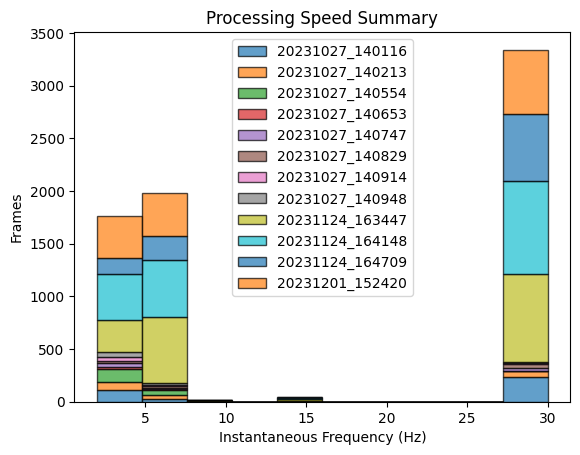

In [108]:
category_data = {}
for category in logs_pdf['date'].unique():
    category_data[category] = logs_pdf[logs_pdf['date'] == category]['t_freq']

# Plot stacked histograms on the same axes
plt.hist(category_data.values(), bins=10, alpha=0.7, edgecolor='black', stacked=True)
plt.legend(category_data.keys(), loc='upper center')
plt.xlabel('Instantaneous Frequency (Hz)')
plt.title('Processing Speed Summary')
plt.ylabel('Frames')


### 3. Frame Accuracy


In [ ]:
for date in np.unique(labels_pdf.date):
    plt.plot(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].x, label='Label')
    plt.plot(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].x,  label='MILTracker (Feb4)')
    plt.scatter(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].x)
    plt.scatter(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].x)
    plt.ylabel('X coordinate')
    plt.xlabel('Unix Timestamps')
    plt.title(date)
    plt.legend()
    plt.show()

In [ ]:
for date in np.unique(labels_pdf.date):
    plt.plot(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].y, label='Label')
    plt.plot(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].y,  label='MILTracker (Feb4)')
    plt.scatter(labels_pdf[labels_pdf['date']==date].t, labels_pdf[labels_pdf['date']==date].y)
    plt.scatter(logs_pdf[logs_pdf['date']==date].t, logs_pdf[logs_pdf['date']==date].y)
    plt.ylabel('X coordinate')
    plt.xlabel('Unix Timestamps')
    plt.title(date)
    plt.legend()
    plt.show()

In [192]:
# Measure
labels_int = interp1d(labels_pdf['t'], labels_pdf['x'], kind='linear', fill_value='extrapolate')
logs_pdf['label_x'] = labels_int(logs_pdf['t'])
logs_pdf['abs_diff'] = np.abs(logs_pdf['label_x'] - logs_pdf['x'])
logs_pdf['correct'] = logs_pdf['abs_diff'] < ERR_THRESH

logs_pdf['elapsed_min'] = logs_pdf.groupby('date')['t'].transform(lambda x: x - x.min()) /60 /1000
df1 = logs_pdf.dropna(subset=('x')).groupby('date')['elapsed_min'].max()
df2 = logs_pdf.dropna(subset=('x')).groupby('date')['correct'].mean() * 100
df3 = logs_pdf.dropna(subset=('x')).groupby('date')['abs_diff'].mean()

#plt.plot(logs_pdf['label_x'])
#plt.plot(logs_pdf['x']) 

C:\Users\finno\AppData\Local\Temp\ipykernel_33704\3593349025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_pdf['label_x'] = labels_int(logs_pdf['t'])
C:\Users\finno\AppData\Local\Temp\ipykernel_33704\3593349025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_pdf['abs_diff'] = np.abs(logs_pdf['label_x'] - logs_pdf['x'])
C:\Users\finno\AppData\Local\Temp\ipykernel_33704\3593349025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [193]:
temp = pd.merge(df1, df2, on='date').reset_index()
plot_df = pd.merge(temp, df3, on='date').reset_index()
change = {
    'date' : 'trial',
    'elapsed_min' : 'duration_minutes',
    'correct' : 'correct_frames_pct',
    'abs_diff' : 'average_pixel_err'
}
plot_df.rename(columns=change, inplace=True)
plot_df['duration_minutes'] = np.round(plot_df['duration_minutes'], 2)
plot_df['correct_frames_pct'] = plot_df['correct_frames_pct'].astype(int)
plot_df['average_pixel_err'] = plot_df['average_pixel_err'].astype(int)
plot_df[['trial', 'duration_minutes', 'correct_frames_pct', 'average_pixel_err']]

,trial,duration_minutes,correct_frames_pct,average_pixel_err
0,20231027_140116,0.61,100,28
1,20231027_140213,0.48,100,34
2,20231027_140554,0.61,100,7
3,20231027_140653,0.15,100,14
4,20231027_140747,0.22,100,20
5,20231027_140829,0.16,100,19
6,20231027_140914,0.19,100,33
7,20231027_140948,0.25,100,20
8,20231124_163447,3.64,76,87
9,20231124_164148,3.95,81,74
